In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import scipy as sp

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [142]:
# read in data
df_NO2 = pd.read_csv('../air_weather_data/NO2_all_stations_cleaned.csv')
df_NO2['date'] = pd.to_datetime(df_NO2['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_NO2 = df_NO2.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [143]:
# drop negative and zero values and interpolate (in order to log transform)
df_NO2[df_NO2 <= 0] = np.NaN
df_NO2.interpolate(inplace=True)

In [144]:
# create lagged values
for i in df_NO2.columns:
    df_NO2[str(i) + ', lag1'] = df_NO2[i].shift(1)

# additional lags for the target station
lags = 2
j = 2
for i in range(lags-1):
    df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan' + ', lag' + \
        str(j)] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(j)
    j += 1

# add lag 24 (since found sign.)
df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan, lag 24'] = df_NO2['NO$_2$, Stockholm Torkel Knutssonsgatan'].shift(24)

# drop NaN values
df_NO2.dropna(inplace=True)

In [196]:
# split into train an test sets
df_NO2_train = df_NO2['2017-01-01 00:00':'2020-01-01 00:00']
df_NO2_test = df_NO2['2021-02-01':]

df_weather_train = df_weather['2017-01-01 00:00':'2020-01-01 00:00']
df_weather_test = df_weather['2021-02-01':]

In [197]:
# index needed if normalizing below
index_train = df_NO2_train.index 
index_test = df_NO2_test.index

In [198]:
# log transform data
df_NO2_train = np.log(df_NO2_train)

In [199]:
# if only some stations are to be included, but include all lagged values at Torkel Knutssonsgatan
stations = [i for i in df_NO2_train.columns if 'Torkel' in i and 'lag' in i] + \
           [
            'NO$_2$, Stockholm Hornsgatan 108 , lag1',
            'NO$_2$, Stockholm Sveavägen 59 , lag1',
            'NO$_2$, Stockholm E4/E20 Lilla Essingen, lag1',
            # 'NO$_2$, Norr Malma, lag1',
            # 'NO$_2$, Stockholm Sveavägen 59 Tak, lag1',
           ]

In [200]:
# create y and X matrix
y_train = df_NO2_train['NO$_2$, Stockholm Torkel Knutssonsgatan']
X_train = df_NO2_train[stations]

In [201]:
# # normalize data
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

X_train = scaler1.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=stations)
X_train.insert(0, 'date', index_train)
X_train.set_index('date', inplace=True)

y_train = scaler2.fit_transform(y_train.to_frame())
y_train = pd.DataFrame(y_train, columns = ['NO$_2$, Torkel Knutssonsgatan'])
y_train.insert(0, 'date', index_train)
y_train.set_index('date', inplace=True)

In [202]:
# np.exp(scaler2.inverse_transform((y_train)))

In [203]:
X_train.insert(0, 'intercept', 1) # insert a 1

In [204]:
# if temporal signals are to be included
w = [0,2,4,5] # 0:temp, 1:atm, 2:RH, 3:precip, 4:solrad, 5:wind 
s = [6,7,8,9] # 6,7:day, 8,9:week, 10,11:year

X_train = X_train.merge(df_weather_train.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_train = df_weather_train.iloc[:,w]
df_weather_norm_train = (df_weather_train - df_weather_train.min())/(df_weather_train.max() - df_weather_train.min())
X_train = X_train.merge(df_weather_norm_train, on='date')

# OLS regression

In [205]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary())#.as_latex())

                                  OLS Regression Results                                 
Dep. Variable:     NO$_2$, Torkel Knutssonsgatan   R-squared:                       0.858
Model:                                       OLS   Adj. R-squared:                  0.858
Method:                            Least Squares   F-statistic:                 1.136e+04
Date:                           Thu, 18 Aug 2022   Prob (F-statistic):               0.00
Time:                                   22:58:37   Log-Likelihood:                 39712.
No. Observations:                          26281   AIC:                        -7.939e+04
Df Residuals:                              26266   BIC:                        -7.927e+04
Df Model:                                     14                                         
Covariance Type:                       nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.

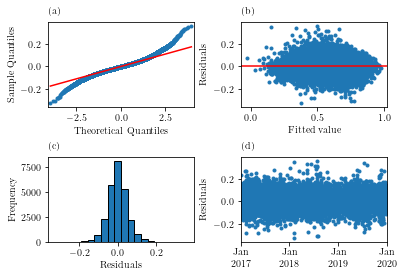

In [206]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5.5, 3.75))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")

ax3.hist(lmod.resid, edgecolor='black', bins=20)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")
ax4.set_xticks([], minor=True)

# plt.savefig('../plots/Residual_plots_MLR_NO2.pdf')

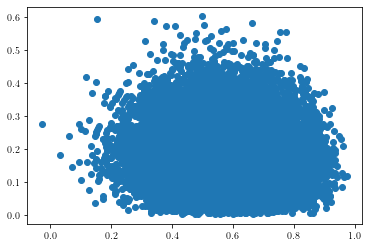

In [207]:
plt.scatter(lmod.fittedvalues, np.sqrt(abs(lmod.resid)))

In [208]:
ddf = pd.DataFrame({'x':lmod.fittedvalues, 'y':np.sqrt((abs(lmod.resid)))})
dmod = smf.ols('y~x', ddf).fit()
dmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.260
Date:                Thu, 18 Aug 2022   Prob (F-statistic):              0.262
Time:                        22:58:41   Log-Likelihood:                 27430.
No. Observations:               26281   AIC:                        -5.486e+04
Df Residuals:                   26279   BIC:                        -5.484e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1820      0.002     78.241      0.000       0.177       0.187
x             -0.0045      0.004     -1.122      0.262      -0.012       0.003
==============================================================================
Omnibus:                     1170.876   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1338.682
Skew:                           0.530   Prob(JB):                    2.04e-291
Kurtosis:                       3.315   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# dfs for new predictions
y_test = df_NO2_test['NO$_2$, Stockholm Torkel Knutssonsgatan'] 
X_test = df_NO2_test[stations]

In [35]:
# log transform test data (but keep the target y in original scale)
X_test = np.log(X_test) 

In [36]:
# normalize X and y 
X_test = scaler1.transform(X_test)
X_test = pd.DataFrame(X_test, columns=stations)
X_test.insert(0, 'date', index_test)
X_test.set_index('date', inplace=True)

In [37]:
X_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [38]:
# if temporal signals are to be included
X_test = X_test.merge(df_weather_test.iloc[:,s], on='date')

# if weather parameters are to be included
df_weather_test = df_weather_test.iloc[:, w]
df_weather_norm_test = (df_weather_test-df_weather_test.min())/(df_weather_test.max()-df_weather_test.min())
X_test = X_test.merge(df_weather_norm_test, on='date')

In [39]:
# check if columns in train and test matrices are same
(X_test.columns == X_train.columns).all()

True

In [40]:
# if not normalized
# y_pred_frame = np.exp(lmod.get_prediction(X_test).summary_frame()) # for confidence intervals
# y_pred = np.exp(lmod.predict(X_test))

# if normalized
y_pred = pd.DataFrame(np.exp(scaler2.inverse_transform(lmod.predict(X_test).to_frame())), columns=['NO$_2$, predictions'])
# y_pred = pd.DataFrame(scaler2.inverse_transform(lmod.predict(X_test).to_frame()), columns=['PM$_{10}$, predictions'])
y_pred.insert(0, 'date', index_test)
y_pred.set_index('date', inplace=True)

In [41]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred, y_test)).round(3))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(100*(mean_absolute_percentage_error(y_pred, y_test).round(5)))

RMSE:
3.531

MAPE:
21.276


# Ridge regression

In [42]:
# from itertools import chain
# from sklearn import linear_model
# from sklearn.model_selection import GridSearchCV

# n_alphas = 250
# alphas = np.logspace(-3, 5, n_alphas)
# coefs = []
# for a in alphas:
#     ridge = linear_model.Ridge(alpha=a)
#     ridge.fit(X_train, y_train)
#     coefs.append(list(chain(*ridge.coef_)))
#     # coefs.append(ridge.coef_)

# # select value of alpha with cross-validation
# pars = {'alpha':np.logspace(-3, 5, n_alphas)}
# rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
# rr.fit(X_train, y_train)
# bestalpha = rr.best_params_['alpha']


# fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
# # ridge trace plot
# ax = plt.gca()
# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])
# for i in range(len(X_train.columns)):
#     ax.text(min(alphas)/3.25, coefs[0][i], X_train.columns[i], fontsize=8)
# ax.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
# ax.set_xlabel(r'$\lambda$')
# ax.set_ylabel('Coefficients')
# plt.savefig('../plots/ridge_trace_plot_NO2.pdf')

In [43]:
# # new predictions with ridge regression
# rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
# rrbest.fit(X_train, y_train)

# print('RMSE:') 
# print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test)).round(5))
# # print(np.sqrt(mean_squared_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test)).round(5))

# print('\nMAPE:')
# print(100*(mean_absolute_percentage_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test))), y_test).round(5)))
# # print(100*(mean_absolute_percentage_error(scaler2.inverse_transform(rrbest.predict(X_test)), y_test).round(5)))

# Robust regression

In [44]:
rlmod = sm.RLM(y_train, X_train).fit()
print(rlmod.summary())

                          Robust linear Model Regression Results                         
Dep. Variable:     NO$_2$, Torkel Knutssonsgatan   No. Observations:                26305
Model:                                       RLM   Df Residuals:                    26290
Method:                                     IRLS   Df Model:                           14
Norm:                                     HuberT                                         
Scale Est.:                                  mad                                         
Cov Type:                                     H1                                         
Date:                           Thu, 18 Aug 2022                                         
Time:                                   19:13:49                                         
No. Iterations:                               23                                         
                                                      coef    std err          z      P>|z|      [0.

In [45]:
# print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rlmod.predict(X_test))), y_test)).round(5))
y_pred_robust = pd.DataFrame(np.exp(scaler2.inverse_transform(rlmod.predict(X_test).to_frame())), columns = ['NO$_2$, predictions'])
# y_pred_robust = pd.DataFrame(scaler2.inverse_transform(rlmod.predict(X_test).to_frame()), columns = ['PM$_{10}$, predictions'])
y_pred_robust.insert(0, 'date', index_test)
y_pred_robust.set_index('date', inplace=True)

In [46]:
# metrics
print('RMSE:')
# print(np.sqrt(mean_squared_error(y_pred_frame['mean'], y_test)).round(4))
print(np.sqrt(mean_squared_error(y_pred_robust, y_test)).round(3))

print('\nMAPE:')
# print(mean_absolute_percentage_error(y_pred_frame['mean'], y_test).round(4))
print(100*(mean_absolute_percentage_error(y_pred_robust, y_test).round(5)))

RMSE:
3.507

MAPE:
21.143
